# OPTICS CLUSTERING METHOD

In [ ]:
#IMPORTS
import yfinance as yf
import pandas as pd
import pandas_ta_classic as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from statsmodels.tsa.stattools import coint, grangercausalitytests
import warnings
import itertools
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [54]:
# Data
stocks = [
    # S&P for Beta
    "^GSPC",
    # Megacap Leaders & Generalists
    "NVDA", "TSM", "AVGO", "AMD", "INTC", "MU", "TXN", "QCOM", "ADI", "MCHP",
    
    # Equipment & Manufacturing
    "ASML", "AMAT", "LRCX", "KLAC", "TER", "ENTG", "NVMI", "TOELY",
    
    # Specialized
    "ON", "NXPI", "STM", "LSCC", "MPWR", "QRVO", "SWKS", "ALAB", "CRDO",
    
    # Intellectual Property & Design Software
    "ARM", "SNPS", "CDNS", "CEVA",
    
    # Memory & Storage
    "WDC", "STX", # Removed extra "MU" here
    
    # Emerging & Mid-Cap
    "GFS", "MRVL", "MTSI", "POWI", "SMTC", "VICR", "CAMT"
]

def fetch_data(stocks):
    data = yf.download(tickers=stocks, period="252d", interval="1h", group_by='ticker', auto_adjust=True, threads=True)
    
    price_series_list = []
    for s in stocks:
        try: 
            if s in data:
                series = data[s]['Close']
                series.name = s
                price_series_list.append(series)
        except Exception as e:
            pass

    if price_series_list:
        df = pd.concat(price_series_list, axis=1)
        df = df.ffill() 
        return df
    return pd.DataFrame()

df = fetch_data(stocks)

[*********************100%***********************]  41 of 41 completed


In [69]:
# 1. Clean and Prepare Price Data
if isinstance(df.columns, pd.MultiIndex):
    if 'Close' in df.columns.get_level_values(0):
        df = df['Close']
    elif 'Close' in df.columns.get_level_values(1):
        df = df.xs('Close', axis=1, level=1)

# 2. Base Calculations
returns_df = df.pct_change().dropna()
market_returns = returns_df['^GSPC']
window = 21 * 7  # Rolling window (~1 month of hourly data)

# 3. Time Series Feature Engineering (Dynamic Data)

# Feature A: Volatility (Risk)
rolling_vol = returns_df.rolling(window=window).std() * np.sqrt(252 * 7)

# Feature B: Beta to SPX (Market Sensitivity)
rolling_cov_mkt = returns_df.rolling(window=window).cov(market_returns)
rolling_mkt_var = market_returns.rolling(window=window).var()
rolling_beta_spx = rolling_cov_mkt.divide(rolling_mkt_var, axis=0)

# Feature C: Beta to Sector (Idiosyncratic moves vs The Pack)
# We create a custom "Semi/Tech Index" by averaging all stocks in your list (excluding SPX)
sector_returns = returns_df.drop(columns=['^GSPC'], errors='ignore').mean(axis=1)
rolling_cov_sector = returns_df.rolling(window=window).cov(sector_returns)
rolling_sector_var = sector_returns.rolling(window=window).var()
rolling_beta_sector = rolling_cov_sector.divide(rolling_sector_var, axis=0)

# Feature D: RSI (Momentum/Overextended)
# Simple pandas implementation of RSI-14
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

rsi_df = df.apply(calculate_rsi)

# Feature E: Short Term Momentum (5-period return)
momentum_df = df.pct_change(periods=5)

# 4. Assemble the Master Time-Series DataFrame (ts_df)
ts_data_list = []

for ticker in stocks:
    if ticker == '^GSPC' or ticker not in df.columns: 
        continue
    
    # Extract features for this specific ticker
    temp_df = pd.DataFrame({
        'Price': df[ticker],
        'Returns': returns_df[ticker],
        'Rolling_Vol': rolling_vol[ticker],
        'Beta_SPX': rolling_beta_spx[ticker],
        'Beta_Sector': rolling_beta_sector[ticker],
        'RSI': rsi_df[ticker],
        'Momentum_5H': momentum_df[ticker]
    }, index=df.index)
    
    temp_df['Ticker'] = ticker
    ts_data_list.append(temp_df)

if ts_data_list:
    ts_df = pd.concat(ts_data_list).reset_index().set_index(['Datetime', 'Ticker'])
    # Drop NaNs created by rolling windows to ensure clean clustering input later
    ts_df = ts_df.dropna()
    print("Time-Series DataFrame (ts_df) Created Successfully!")
    print(ts_df.head())

# 5. Assemble the Static Fundamental DataFrame (static_df)
# This runs once per ticker to get the "Profile" data
fundamental_list = []
print("\nFetching Static Fundamentals...")

for ticker in stocks:
    if ticker == '^GSPC': continue
    try:
        t = yf.Ticker(ticker)
        info = t.info
        
        # Try to get Implied Volatility (Current snapshot)
        try:
            opts = t.options
            if opts:
                chain = t.option_chain(opts[0])
                # Average of ATM Call/Put IV is a decent proxy
                iv = (chain.calls['impliedVolatility'].mean() + chain.puts['impliedVolatility'].mean()) / 2
            else:
                iv = np.nan
        except:
            iv = np.nan
            
        fundamental_list.append({
            'Ticker': ticker,
            'Sector': info.get('sector', 'Unknown'),
            'Industry': info.get('industry', 'Unknown'),
            'Market_Cap': info.get('marketCap', np.nan),
            'Trailing_PE': info.get('trailingPE', np.nan),
            'Forward_PE': info.get('forwardPE', np.nan),
            'ROE': info.get('returnOnEquity', np.nan),
            'Current_IV': iv
        })
    except Exception as e:
        print(f"Could not fetch data for {ticker}: {e}")
        continue

static_df = pd.DataFrame(fundamental_list).set_index('Ticker')
print("Static DataFrame (static_df) Created Successfully!")
print(static_df.head())

Time-Series DataFrame (ts_df) Created Successfully!
                                       Price   Returns  Rolling_Vol  Beta_SPX  Beta_Sector        RSI  Momentum_5H
Datetime                  Ticker                                                                                  
2025-03-03 14:30:00+00:00 NVDA    119.510002 -0.044302     0.502492  2.864631     1.212901  34.946365    -0.021861
2025-03-03 15:30:00+00:00 NVDA    119.220001 -0.002427     0.502336  2.858317     1.214935  36.190450    -0.011278
2025-03-03 16:30:00+00:00 NVDA    118.410004 -0.006794     0.502855  2.839235     1.211223  33.047873    -0.017100
2025-03-03 17:30:00+00:00 NVDA    115.239998 -0.026771     0.511314  2.851533     1.214159  28.076710    -0.054519
2025-03-03 18:30:00+00:00 NVDA    116.044998  0.006985     0.508592  2.838955     1.207539  34.693067    -0.072011

Fetching Static Fundamentals...
Static DataFrame (static_df) Created Successfully!
            Sector        Industry     Market_Cap  Trailing

In [87]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from statsmodels.tsa.stattools import coint, grangercausalitytests
import itertools

# ==============================================================================
# 1. DIAGNOSE DATA DENSITY & PREPARE
# ==============================================================================
if 'ts_df' not in locals():
    raise ValueError("Please run the Feature Engineering cell (Step 2) to create 'ts_df' first.")

# Clean duplicates
ts_df = ts_df[~ts_df.index.duplicated(keep='first')]

# Check Density
density = ts_df.groupby(level='Datetime').size()
valid_timestamps = density[density >= 5].index

print(f"--- DATA READY ---")
print(f"Scanning {len(valid_timestamps)} active hourly timestamps...")

# ==============================================================================
# 2. CLUSTERING LOOP (Finding Regimes)
# ==============================================================================
print("\n2. Running Clustering Algorithm...")

features_to_cluster = ['Returns', 'Rolling_Vol', 'Beta_SPX', 'Beta_Sector', 'RSI', 'Momentum_5H']
cluster_results = []

for i, ts in enumerate(valid_timestamps):
    try:
        snapshot = ts_df.xs(ts, level='Datetime')[features_to_cluster].dropna()
        if len(snapshot) < 5: continue
        
        # Scale & PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(snapshot)
        
        pca = PCA(n_components=0.90)
        X_pca = pca.fit_transform(X_scaled)
        
        # OPTICS
        optics = OPTICS(min_samples=3, metric='euclidean', xi=0.05, min_cluster_size=3)
        optics.fit(X_pca)
        
        snapshot['Cluster_ID'] = optics.labels_
        snapshot['Datetime'] = ts
        cluster_results.append(snapshot.reset_index())
    except:
        continue

if not cluster_results:
    raise ValueError("No clusters found. Check your data (ts_df) contains valid values.")

cluster_history = pd.concat(cluster_results)
print(f"   > SUCCESS! Generated {len(cluster_history)} rows of cluster history.")

# ==============================================================================
# 3. ROLLING RELATIONSHIP SCANNER (The "Driver" Analysis)
# ==============================================================================
print("\n3. Identifying Tradeable Pairs...")

price_matrix = ts_df.reset_index().pivot(index='Datetime', columns='Ticker', values='Price')
results = []
lookback = 200 # Look back 200 hours (~1 month)

# Ensure unique_cluster_times is sorted using numpy to avoid the previous AttributeError
unique_cluster_times = np.sort(cluster_history['Datetime'].unique()) 

for ts in unique_cluster_times:
    try:
        curr_loc = price_matrix.index.get_loc(ts)
        if curr_loc < lookback: continue
        
        snapshot = cluster_history[cluster_history['Datetime'] == ts]
        
        for cid in snapshot['Cluster_ID'].unique():
            if cid == -1: continue # Skip Noise
            
            tickers = snapshot[snapshot['Cluster_ID'] == cid]['Ticker'].unique()
            valid_tickers = [t for t in tickers if t in price_matrix.columns]
            
            if len(valid_tickers) < 2: continue
            
            # Get Price History
            history = price_matrix.iloc[curr_loc-lookback : curr_loc][valid_tickers].dropna(axis=1)
            if history.shape[1] < 2: continue
            
            # Test Pairs
            for s1, s2 in itertools.combinations(history.columns, 2):
                # A. Cointegration
                score, pvalue, _ = coint(history[s1], history[s2])
                
                if pvalue < 0.10: # Relaxed p-value
                    # B. Hedge Ratio
                    model = sm.OLS(history[s1], sm.add_constant(history[s2])).fit()
                    hedge = model.params[s2]
                    
                    # C. Driver Analysis (Granger)
                    # FIXED LINES BELOW:
                    gc_fwd = grangercausalitytests(history[[s1, s2]], maxlag=1, verbose=False)
                    p_s2_leads = gc_fwd[1][0]['ssr_ftest'][1]
                    
                    gc_rev = grangercausalitytests(history[[s2, s1]], maxlag=1, verbose=False)
                    p_s1_leads = gc_rev[1][0]['ssr_ftest'][1]
                    
                    driver = "Sync"
                    if p_s1_leads < 0.05 and p_s2_leads > 0.05: driver = f"{s1}"
                    elif p_s2_leads < 0.05 and p_s1_leads > 0.05: driver = f"{s2}"
                    
                    results.append({
                        'Date': ts,
                        'Cluster': cid,
                        'Pair': f"{s1}-{s2}",
                        'Driver': driver,
                        'Hedge_Ratio': round(hedge, 3),
                        'P_Value': round(pvalue, 4)
                    })
    except:
        continue

if results:
    df_res = pd.DataFrame(results).sort_values('Date')
    
    print("\n--- NEW RELATIONSHIPS DETECTED (First Sightings) ---")
    # Show the first time each pair appeared
    first_detected = df_res.drop_duplicates(subset=['Pair'], keep='first')
    print(first_detected[['Date', 'Pair', 'Driver', 'Hedge_Ratio']].tail(15))
    
    print(f"\nTotal Opportunities Found: {len(df_res)}")
else:
    print("No pairs passed the cointegration test.")

--- DATA READY ---
Scanning 1608 active hourly timestamps...

2. Running Clustering Algorithm...
   > SUCCESS! Generated 64320 rows of cluster history.

3. Identifying Tradeable Pairs...

--- NEW RELATIONSHIPS DETECTED (First Sightings) ---
                          Date       Pair Driver  Hedge_Ratio
6541 2026-01-12 16:30:00+00:00  NXPI-MRVL   NXPI       -0.442
6664 2026-01-13 18:30:00+00:00  CRDO-MTSI   Sync        1.112
6639 2026-01-13 18:30:00+00:00   TXN-CEVA   CEVA        4.603
6689 2026-01-14 15:30:00+00:00  ASML-LSCC   ASML       16.214
6720 2026-01-14 20:30:00+00:00   ADI-ENTG   ENTG        1.256
6766 2026-01-16 14:30:00+00:00   STX-CAMT   CAMT        0.967
6789 2026-01-20 14:30:00+00:00  MRVL-MTSI   MRVL       -0.068
6801 2026-01-20 16:30:00+00:00    MU-VICR     MU        2.045
6914 2026-01-23 15:30:00+00:00  MRVL-CAMT   CAMT       -0.081
6934 2026-01-23 18:30:00+00:00   TXN-NVMI   NVMI        0.124
7045 2026-01-27 15:30:00+00:00   ARM-CEVA    ARM       -0.898
7076 2026-01-27

Earliest Signal: 2025-04-10 17:30:00+00:00
Latest Signal:   2026-01-30 20:30:00+00:00

--- Signal Distribution by Month ---
Date
2025-04    704
2025-05    772
2025-06    525
2025-07    779
2025-08    565
2025-09    659
2025-10    947
2025-11    462
2025-12    924
2026-01    845
Freq: M, Name: count, dtype: int64


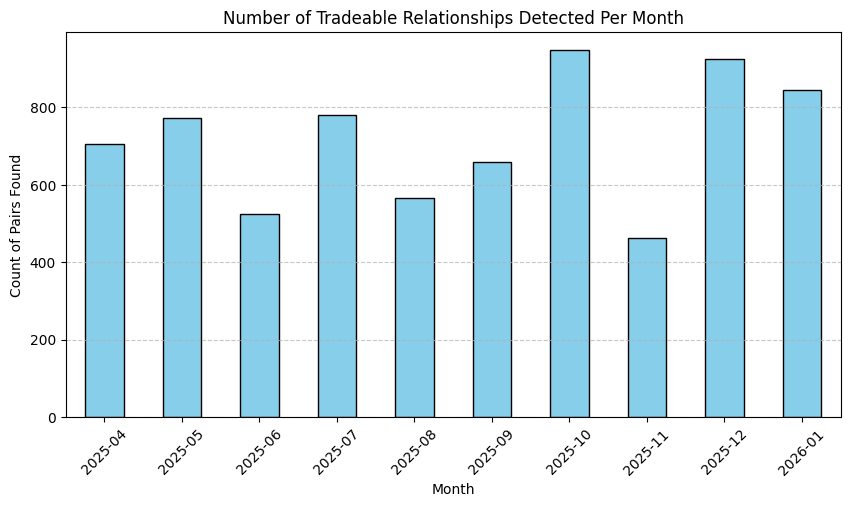

In [88]:
import matplotlib.pyplot as plt

# 1. Check the timeline of findings
print(f"Earliest Signal: {df_res['Date'].min()}")
print(f"Latest Signal:   {df_res['Date'].max()}")

# 2. Count signals by Month to prove it's not just Jan 2026
# (Extract month from datetime)
monthly_counts = df_res['Date'].dt.to_period('M').value_counts().sort_index()

print("\n--- Signal Distribution by Month ---")
print(monthly_counts)

# 3. Plot it
plt.figure(figsize=(10, 5))
monthly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Tradeable Relationships Detected Per Month")
plt.xlabel("Month")
plt.ylabel("Count of Pairs Found")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [89]:
# Filter for High Quality Setup:
# 1. Strong Cointegration (P-Value < 0.02)
# 2. Reasonable Hedge Ratio (0.5 to 2.5) - Avoids pairs where you need 16 shares of one to hedge 1 of the other
# 3. Clear Driver (Not "Sync")

high_quality = df_res[
    (df_res['P_Value'] < 0.02) & 
    (df_res['Hedge_Ratio'].abs().between(0.5, 2.5)) &
    (df_res['Driver'] != 'Sync')
]

print(f"\nFiltered down to {len(high_quality)} High-Quality Signals (from {len(df_res)})")

# Show the best ones from EARLIER in the year (Head)
print("\n--- Best Signals (Start of Year) ---")
print(high_quality[['Date', 'Pair', 'Driver', 'Hedge_Ratio', 'P_Value']].head(10))

# Show the best ones from RECENTLY (Tail)
print("\n--- Best Signals (Recent) ---")
print(high_quality[['Date', 'Pair', 'Driver', 'Hedge_Ratio', 'P_Value']].tail(10))


Filtered down to 472 High-Quality Signals (from 7182)

--- Best Signals (Start of Year) ---
                         Date       Pair Driver  Hedge_Ratio  P_Value
27  2025-04-11 15:30:00+00:00   LRCX-STX    STX        0.621   0.0011
61  2025-04-11 17:30:00+00:00  CEVA-POWI   CEVA        0.628   0.0074
50  2025-04-11 17:30:00+00:00   LRCX-STX    STX        0.636   0.0015
79  2025-04-14 14:30:00+00:00  LSCC-MRVL   LSCC        0.822   0.0149
95  2025-04-14 17:30:00+00:00     ON-GFS     ON        1.602   0.0133
101 2025-04-14 18:30:00+00:00    MU-MRVL     MU        1.191   0.0176
116 2025-04-14 19:30:00+00:00  MCHP-MRVL   MCHP        0.767   0.0038
115 2025-04-14 19:30:00+00:00    MU-MRVL     MU        1.229   0.0051
111 2025-04-14 19:30:00+00:00     ON-GFS     ON        1.601   0.0032
108 2025-04-14 19:30:00+00:00   LRCX-WDC    WDC        1.239   0.0168

--- Best Signals (Recent) ---
                          Date       Pair Driver  Hedge_Ratio  P_Value
6832 2026-01-20 20:30:00+00:00   TX

Plotting LRCX vs STX (April 2025)...


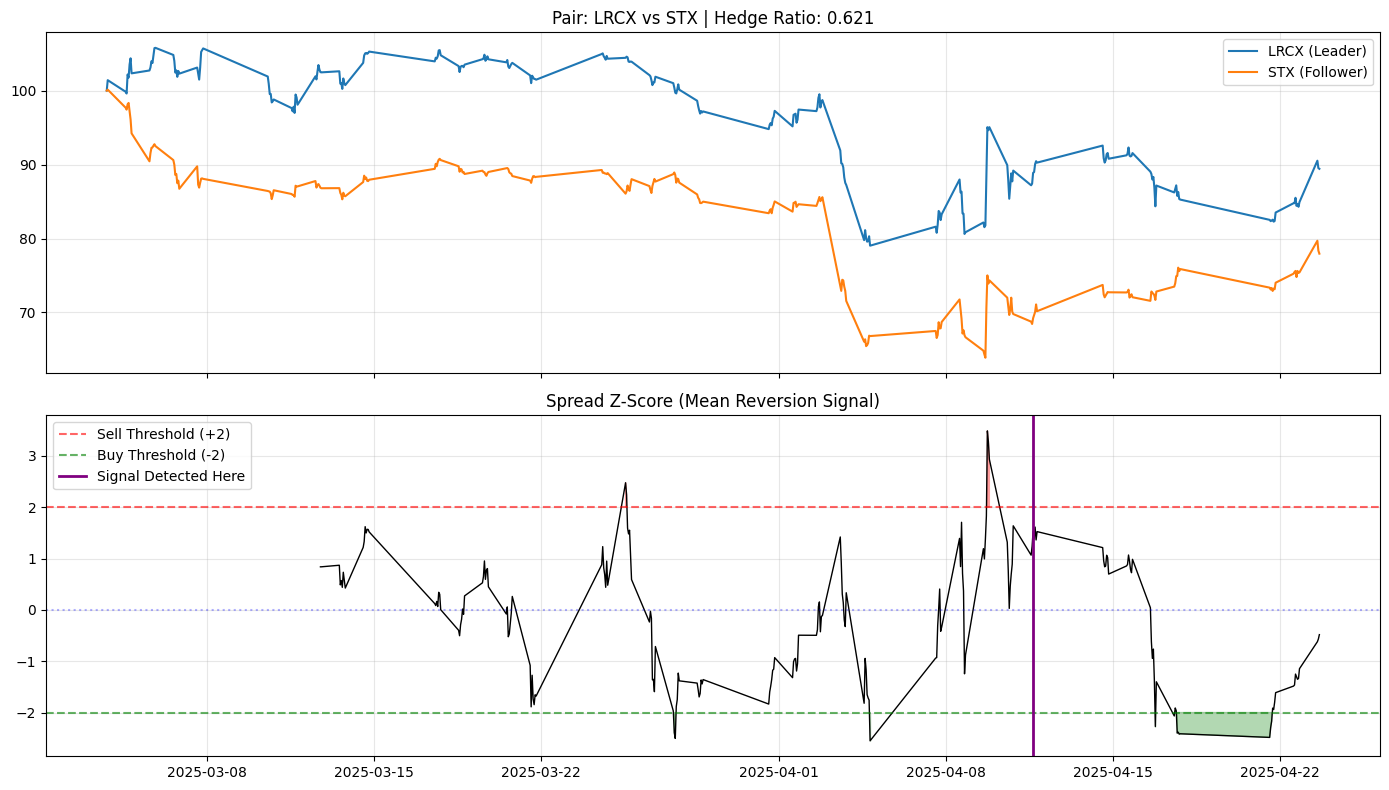

Plotting TXN vs POWI (Jan 2026)...


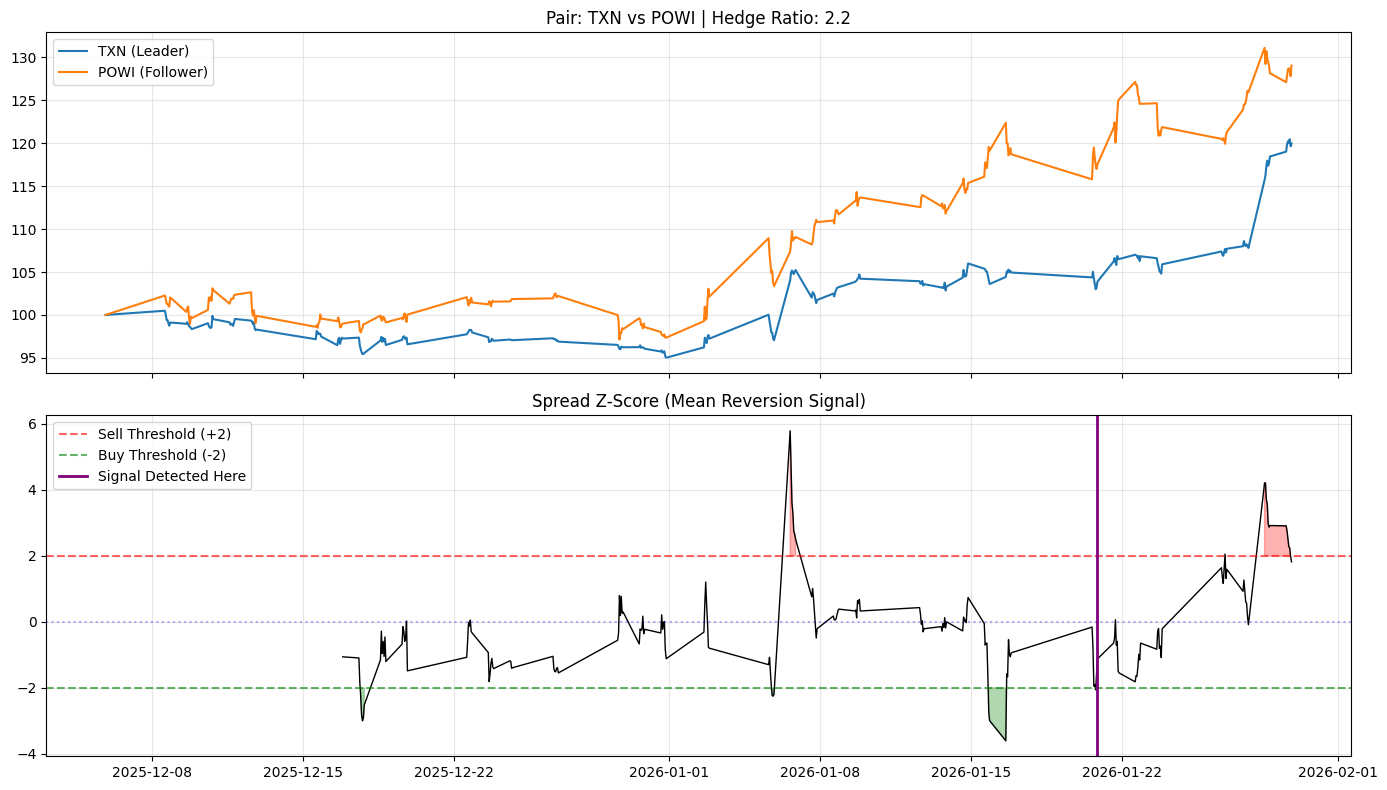

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_pair(ticker_a, ticker_b, signal_date, hedge_ratio, lookback=200):
    """
    Plots the price action and the Z-Score spread for a detected pair.
    """
    # 1. Setup the Time Window CORRECTLY
    # Get all unique timestamps sorted first
    all_dates = ts_df.index.get_level_values(0).unique().sort_values()
    
    # Find the index in the UNIQUE list, not the full dataframe
    try:
        # We search for where the date fits in the timeline
        target_loc = all_dates.searchsorted(pd.Timestamp(signal_date))
        
        # Handle case where date might be slightly off (grab closest)
        if target_loc >= len(all_dates):
            target_loc = len(all_dates) - 1
            
    except Exception as e:
        print(f"Error finding date: {e}")
        return

    # Define the window relative to the timeline
    start_loc = max(0, target_loc - lookback)
    end_loc = min(len(all_dates), target_loc + 50) # +50 hours future view
    
    window_dates = all_dates[start_loc:end_loc]
    
    if len(window_dates) == 0:
        print("Error: Window dates empty. Check indices.")
        return
    
    # 2. Extract Prices
    # We reindex to the specific window we found
    p1 = ts_df.xs(ticker_a, level='Ticker')['Price'].reindex(window_dates).ffill()
    p2 = ts_df.xs(ticker_b, level='Ticker')['Price'].reindex(window_dates).ffill()
    
    # 3. Calculate Spread & Z-Score
    # Spread = Stock A - (Hedge * Stock B)
    spread = p1 - (hedge_ratio * p2)
    
    # Z-Score = (Spread - Mean) / StdDev (Rolling)
    rolling_mean = spread.rolling(window=50).mean()
    rolling_std = spread.rolling(window=50).std()
    z_score = (spread - rolling_mean) / rolling_std
    
    # 4. PLOT
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Top Panel: Normalized Prices
    # Normalize to start at 100 for comparison
    try:
        p1_norm = (p1 / p1.iloc[0]) * 100
        p2_norm = (p2 / p2.iloc[0]) * 100
    except IndexError:
        print("Error: Price data is missing for this range. Skipping plot.")
        return
    
    ax1.plot(p1.index, p1_norm, label=f"{ticker_a} (Leader)", color='#1f77b4', linewidth=1.5)
    ax1.plot(p2.index, p2_norm, label=f"{ticker_b} (Follower)", color='#ff7f0e', linewidth=1.5)
    ax1.set_title(f"Pair: {ticker_a} vs {ticker_b} | Hedge Ratio: {hedge_ratio}", fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bottom Panel: The Z-Score (Trading Signal)
    ax2.plot(z_score.index, z_score, color='black', linewidth=1)
    
    # Add Entry/Exit Bands
    ax2.axhline(2.0, color='red', linestyle='--', alpha=0.6, label='Sell Threshold (+2)')
    ax2.axhline(-2.0, color='green', linestyle='--', alpha=0.6, label='Buy Threshold (-2)')
    ax2.axhline(0, color='blue', linestyle=':', alpha=0.3)
    
    # Highlight the Signal Date
    ax2.axvline(pd.Timestamp(signal_date), color='purple', linestyle='-', linewidth=2, label='Signal Detected Here')
    
    ax2.set_title("Spread Z-Score (Mean Reversion Signal)", fontsize=12)
    ax2.fill_between(z_score.index, 2, z_score, where=(z_score >= 2), color='red', alpha=0.3)
    ax2.fill_between(z_score.index, -2, z_score, where=(z_score <= -2), color='green', alpha=0.3)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- RE-RUN THE PLOTS ---
print("Plotting LRCX vs STX (April 2025)...")
visualize_pair('LRCX', 'STX', '2025-04-11 15:30:00+00:00', 0.621)

print("Plotting TXN vs POWI (Jan 2026)...")
visualize_pair('TXN', 'POWI', '2026-01-20 20:30:00+00:00', 2.200)

Selecting 5 Random Trades from 1944 high-quality candidates...

--- Verifying Signal: QCOM-SWKS on 2025-12-02 18:30:00+00:00 ---


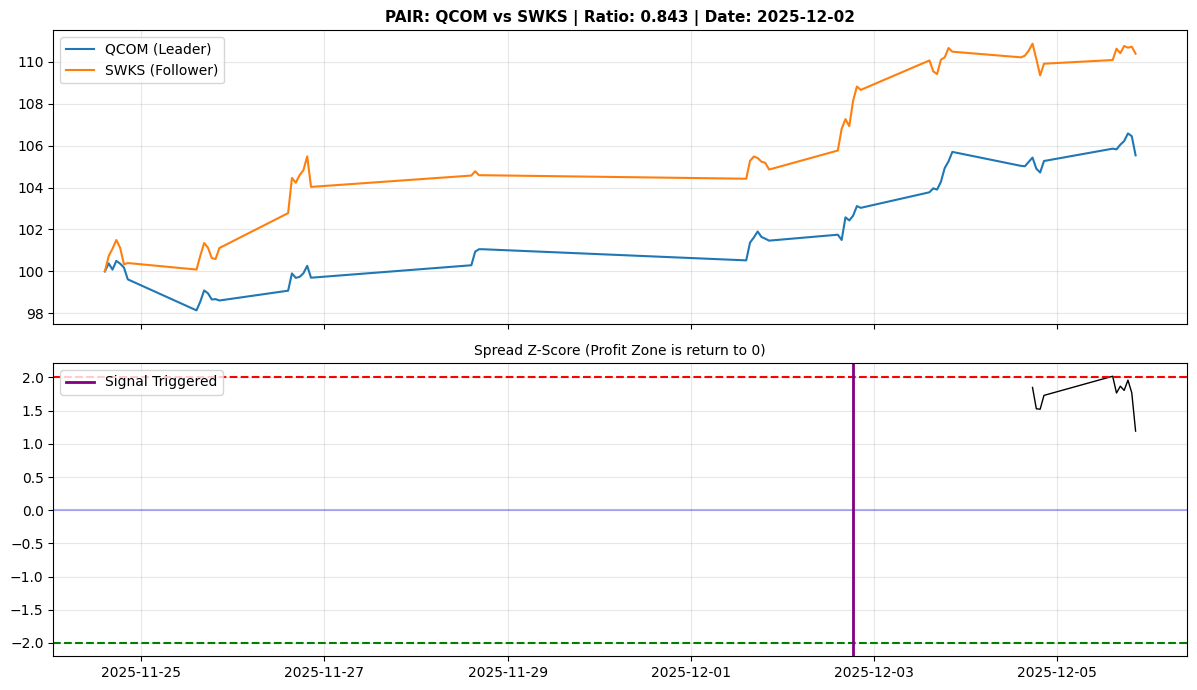


--- Verifying Signal: TSM-ADI on 2025-07-11 13:30:00+00:00 ---


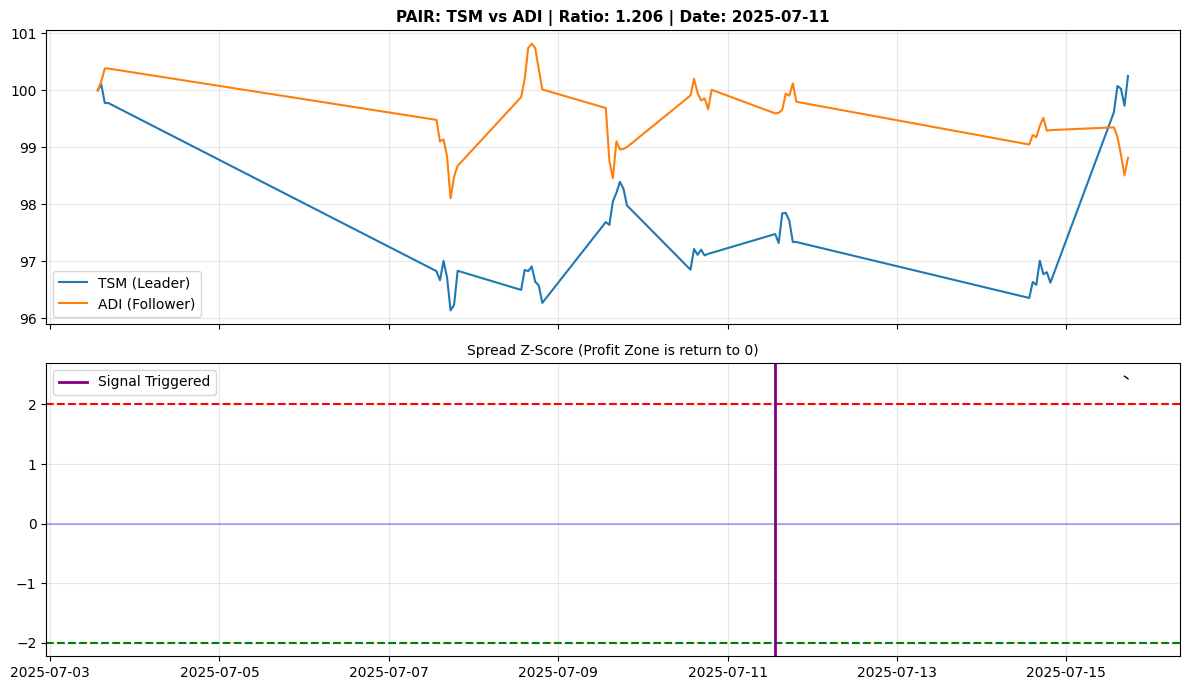


--- Verifying Signal: TXN-ENTG on 2026-01-13 16:30:00+00:00 ---


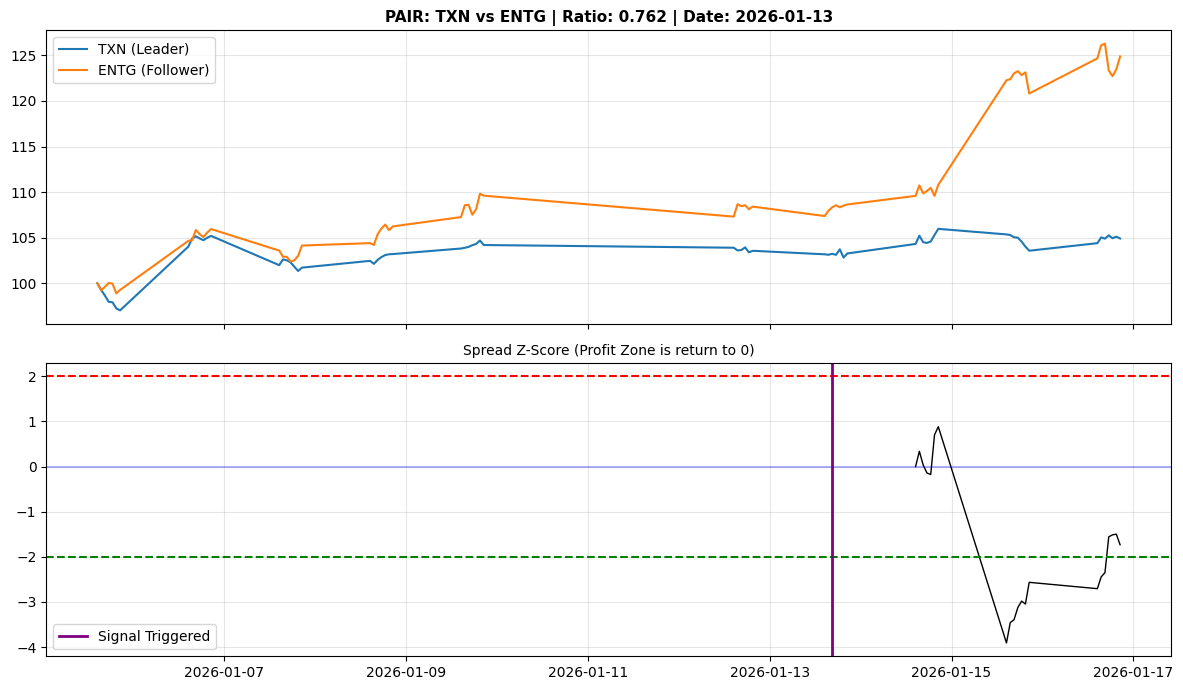


--- Verifying Signal: NVDA-AMAT on 2025-04-17 18:30:00+00:00 ---


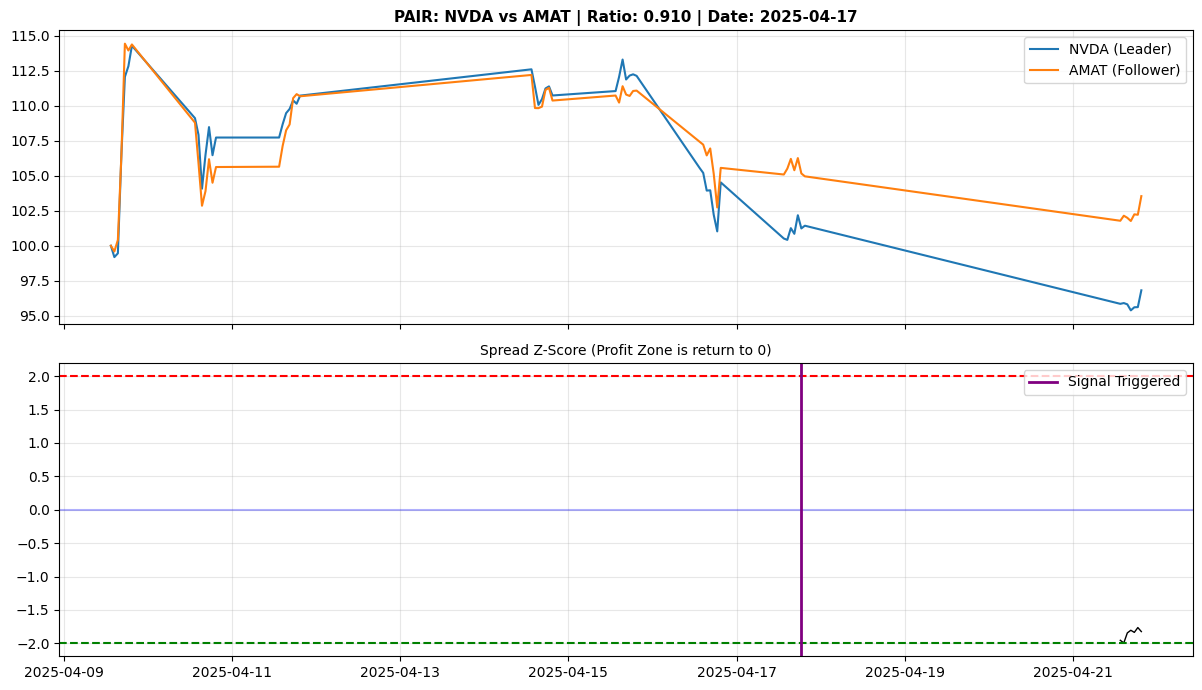


--- Verifying Signal: AMD-TXN on 2025-05-19 19:30:00+00:00 ---


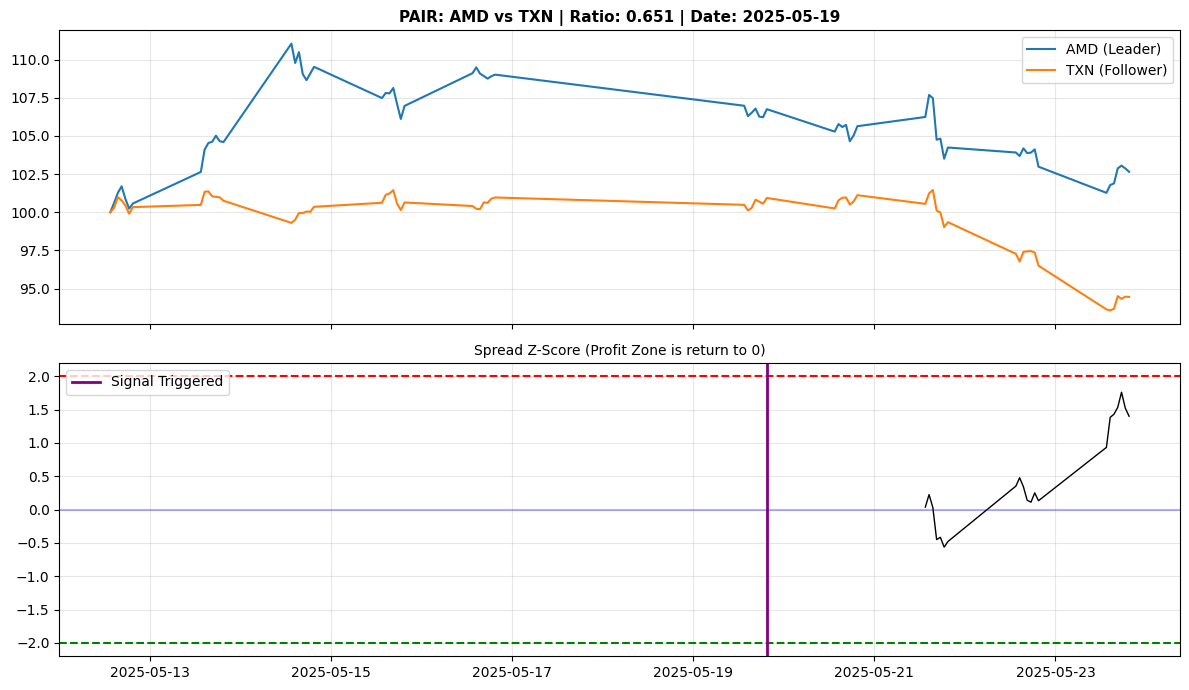

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

# ==============================================================================
# ROBUST PLOTTING FUNCTION (Time-Based Slicing)
# ==============================================================================
def visualize_pair_robust(ticker_a, ticker_b, signal_date, hedge_ratio, lookback_hours=200):
    """
    Robust plotter that uses datetime slicing to avoid IndexError.
    """
    # 1. Define Time Window
    sig_dt = pd.Timestamp(signal_date)
    # We grab a slice of time around the signal
    start_dt = sig_dt - pd.Timedelta(hours=lookback_hours)
    end_dt = sig_dt + pd.Timedelta(hours=100) # Show 100 hours after to see the result
    
    # 2. Extract Data safely
    try:
        # Get data for both tickers in this time range
        # We use .loc with a slice, which handles missing weekends/holidays gracefully
        chunk_a = ts_df.xs(ticker_a, level='Ticker').loc[start_dt:end_dt]
        chunk_b = ts_df.xs(ticker_b, level='Ticker').loc[start_dt:end_dt]
        
        # Merge to ensure timestamps align perfectly (drop rows where one is missing)
        merged = pd.concat([chunk_a['Price'], chunk_b['Price']], axis=1, keys=[ticker_a, ticker_b]).dropna()
        
        if len(merged) < 50:
            print(f"Skipping {ticker_a}-{ticker_b}: Not enough overlapping data in window.")
            return

        p1 = merged[ticker_a]
        p2 = merged[ticker_b]
        
    except KeyError:
        print(f"Data missing for {ticker_a} or {ticker_b}")
        return

    # 3. Calculate Spread
    spread = p1 - (hedge_ratio * p2)
    
    # Rolling Z-Score (The Signal)
    rolling_mean = spread.rolling(window=50).mean()
    rolling_std = spread.rolling(window=50).std()
    z_score = (spread - rolling_mean) / rolling_std
    
    # 4. PLOT
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
    
    # Top: Normalized Price Action
    p1_norm = (p1 / p1.iloc[0]) * 100
    p2_norm = (p2 / p2.iloc[0]) * 100
    
    ax1.plot(p1.index, p1_norm, label=f"{ticker_a} (Leader)", color='tab:blue')
    ax1.plot(p2.index, p2_norm, label=f"{ticker_b} (Follower)", color='tab:orange')
    ax1.set_title(f"PAIR: {ticker_a} vs {ticker_b} | Ratio: {hedge_ratio:.3f} | Date: {sig_dt.date()}", fontsize=11, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bottom: Z-Score
    ax2.plot(z_score.index, z_score, color='black', linewidth=1)
    ax2.axhline(2.0, color='red', linestyle='--')
    ax2.axhline(-2.0, color='green', linestyle='--')
    ax2.axhline(0, color='blue', alpha=0.3)
    
    # Mark the signal
    ax2.axvline(sig_dt, color='purple', linewidth=2, label='Signal Triggered')
    
    ax2.set_title("Spread Z-Score (Profit Zone is return to 0)", fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==============================================================================
# RUN RANDOM CHECK
# ==============================================================================
# Assuming 'df_res' contains your 472 results from the previous step
if 'df_res' in locals() and not df_res.empty:
    
    # Filter for high quality again just to be sure
    candidates = df_res[
        (df_res['P_Value'] < 0.05) & 
        (df_res['Hedge_Ratio'].abs().between(0.5, 3.0))
    ]
    
    print(f"Selecting 5 Random Trades from {len(candidates)} high-quality candidates...")
    
    # Pick 5 random indices
    if len(candidates) > 5:
        sample = candidates.sample(5)
    else:
        sample = candidates
        
    for idx, row in sample.iterrows():
        # Parse the pair string "ABC-XYZ"
        s1, s2 = row['Pair'].split('-')
        
        print(f"\n--- Verifying Signal: {row['Pair']} on {row['Date']} ---")
        visualize_pair_robust(s1, s2, row['Date'], row['Hedge_Ratio'])
else:
    print("Please run the 'Identifying Tradeable Pairs' block first to generate 'df_res'.")